# Predict Next Purchase

In this example, we will generate labels on online grocery orders provided by Instacart using Compose. The labels can be used to train a machine learning model to predict whether a customer will buy a specific product within the next month.

If you plan to run this notebook, you can use the following command at the root directory of the repository.

```bash
jupyter notebook docs/source/examples/predict-next-purchase/example.ipynb
```

## Load Data

In [1]:
%matplotlib inline
import composeml as cp
import data

The data hosted [here](https://www.instacart.com/datasets/grocery-shopping-2017) will be downloaded automatically into the `data` module of this notebook unless it already exist. Once the data is in place, we can preview the grocery orders to see how they look.

In [2]:
df = data.load_orders(nrows=1000000)

df.head()

Downloaded: 206MB / 206MB - 1.04s/MB, Elapsed: 03:34, Remaining: 00:00, Progress: 100%|██████████


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,order_time
0,120,33120,13,0,Organic Egg Whites,86,16,dairy eggs,23750,2015-01-11 08:00:00
1,120,31323,7,0,Light Wisconsin String Cheese,21,16,dairy eggs,23750,2015-01-11 08:00:00
2,120,1503,8,0,Low Fat Cottage Cheese,108,16,dairy eggs,23750,2015-01-11 08:00:00
3,120,28156,11,0,Total 0% Nonfat Plain Greek Yogurt,120,16,dairy eggs,23750,2015-01-11 08:00:00
4,120,41273,4,0,Broccoli Florets,123,4,produce,23750,2015-01-11 08:00:00


## Generate Labels
Now with the grocery orders loaded, we are ready to generate labels for our prediction problem.

### Create Labeling Function
To get started, we define the labeling function that will return whether a customer purchased the product in a given month.

In [3]:
def bought_product(df, product_name):
    purchased = df.product_name.str.contains(product_name).any()
    return purchased

### Construct Label Maker

With the labeling function, we create the label maker for our prediction problem. To process one month of orders for each customer, we set the `target_entity` to the customer ID and the `window_size` to one month. When window size is set to `1MS`, the window size will end on the first day of the next month. Alias definitions are listed [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

In [4]:
lm = cp.LabelMaker(
    target_entity='user_id',
    time_index='order_time',
    labeling_function=bought_product,
    window_size='1MS',
)

### Search Labels
Next, the label maker will search through the data continously to label whether a customer bought bananas in a given month. This happens when we use `LabelMaker.search` and set the `product_name` to bananas. If you are running this code yourself, feel free to expirement with other products (e.g. limes, avocados, etc.) and different time frames!

In [5]:
lt = lm.search(
    df.sort_values('order_time'),
    minimum_data='2015-01-01',
    num_examples_per_instance=-1,
    product_name='Banana',
    verbose=True,
)

lt.head()

Elapsed: 00:38 | Remaining: 00:00 | Progress: 100%|██████████| user_id: 19477/19477 


,bought_product,cutoff_time,user_id
id,,,
0,False,2015-01-01,4
1,False,2015-01-01,7
2,False,2015-01-01,10
3,False,2015-02-01,10
4,False,2015-01-01,13


### Describe Labels

With the generate label times, we can use `LabelTimes.describe` to print out the distribution with the settings and transforms that were used to make these labels. This is useful as a reference for understanding how the labels were generated from raw data. Also, the label distribution is helpful for determining if we have imbalanced labels.

In [6]:
lt.describe()

Label Distribution
------------------
False     13752
True       7044
Total:    20796


Settings
--------
gap                                    None
label_type                         discrete
labeling_function            bought_product
minimum_data                     2015-01-01
num_examples_per_instance                -1
target_entity                       user_id
window_size                    <MonthBegin>


Transforms
----------
No transforms applied



### Plot Labels

Additionally, there are plots available for insight to the labels.


#### Distribution

This plot shows the label distribution.

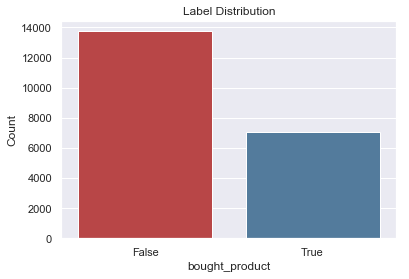

In [7]:
lt.plot.distribution();

#### Count by Time

This plot shows the label distribution across cutoff times.

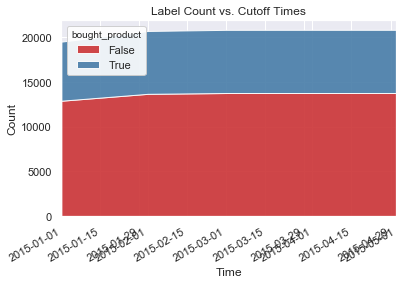

In [8]:
lt.plot.count_by_time();